In [0]:
# # 1) Upgrade typing_extensions to a version MLflow expects
# %pip install --upgrade typing_extensions

# %pip install alpaca_trade_api

# # 2) Install (or reinstall) MLflow
# %pip install --upgrade mlflow

# %pip install xgboost

# # 3) Restart the Python process so the new packages take effect
# dbutils.library.restartPython()

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-334ff9d8-98ea-4eb2-8053-694a6799f844
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-334ff9d8-98ea-4eb2-8053-694a6799f844
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsaf

In [0]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST
from pyspark.sql.functions import to_timestamp, col


# Initialize the REST client (v2 data+trading):
client = REST(
    "PKY96P1SK8M1NUKCCYSC", 
    "Uf15nvt1cNm61OVbKudbnmwqhW155pr3PtdaB4gR", 
    base_url="https://data.alpaca.markets", 
    api_version="v2"
)

# Fetch 15-minute bars for SPY:
bars = client.get_bars(
    "SPY", 
    tradeapi.TimeFrame(15, tradeapi.TimeFrameUnit.Minute),
    start="2024-05-08", 
    end="2025-05-08"
)
df = bars.df

spy_pdf = df.reset_index().rename(columns={"index":"timestamp"})

# 5) Convert to Spark DataFrame
stock_df = spark.createDataFrame(spy_pdf) \
    .withColumn("timestamp", to_timestamp(col("timestamp")))

display(stock_df.limit(10))


timestamp,close,high,low,trade_count,open,volume,vwap
2024-05-08T08:00:00.000+0000,517.31,517.39,517.31,65,517.37,3394,517.319683
2024-05-08T08:15:00.000+0000,517.63,517.63,517.4,12,517.41,1391,517.562308
2024-05-08T08:30:00.000+0000,517.26,517.54,517.26,22,517.54,3239,517.345726
2024-05-08T08:45:00.000+0000,517.18,517.32,517.18,24,517.32,2069,517.244971
2024-05-08T09:00:00.000+0000,517.3,517.35,517.15,29,517.16,4638,517.308106
2024-05-08T09:15:00.000+0000,517.27,517.27,517.16,13,517.16,1385,517.19059
2024-05-08T09:30:00.000+0000,517.35,517.35,517.19,16,517.19,2515,517.212762
2024-05-08T09:45:00.000+0000,517.35,517.52,517.35,11,517.45,1161,517.461747
2024-05-08T10:00:00.000+0000,517.22,517.43,517.08,44,517.3,5984,517.200168
2024-05-08T10:15:00.000+0000,517.27,517.27,517.12,10,517.12,1423,517.240313


In [0]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# 1) Quick schema + row count
print("Schema:")
stock_df.printSchema()
print(f"Total rows: {stock_df.count()}")

# 2) Null / missing values per column
stock_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in stock_df.columns
]).show()

# 3) Basic descriptive statistics
stock_df.describe(["open","high","low","close","volume"]).show()




Schema:
root
 |-- timestamp: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- trade_count: long (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- vwap: double (nullable = true)

Total rows: 16019
+---------+-----+----+---+-----------+----+------+----+
|timestamp|close|high|low|trade_count|open|volume|vwap|
+---------+-----+----+---+-----------+----+------+----+
|        0|    0|   0|  0|          0|   0|     0|   0|
+---------+-----+----+---+-----------+----+------+----+

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|             open|              high|               low|             close|            volume|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|            16019|             16019|             16019|         

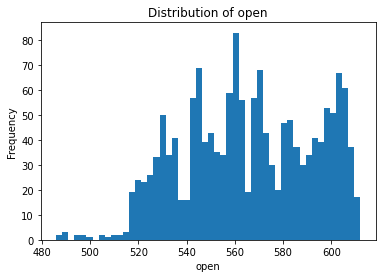

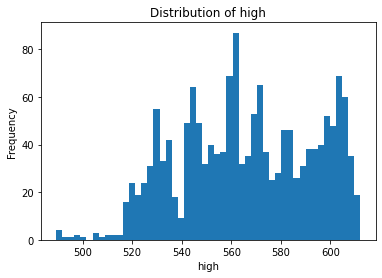

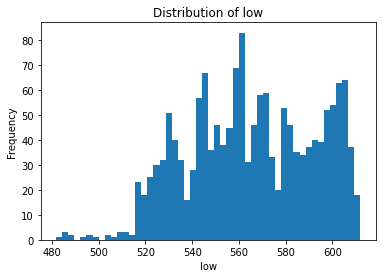

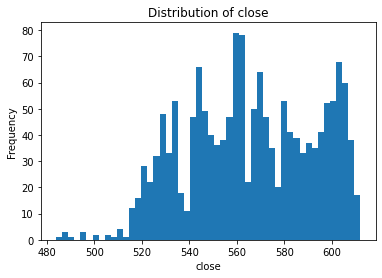

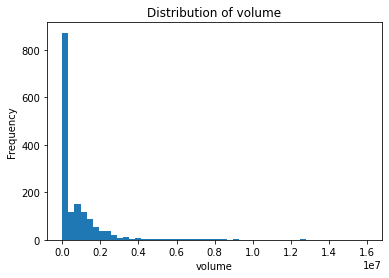

In [0]:
import matplotlib.pyplot as plt

# (1) Pull a sample to Pandas
pdf = stock_df.select("open","high","low","close","volume") \
    .sample(fraction=0.1, seed=42) \
    .toPandas()

# (2) Plot each as its own histogram
for col in ["open","high","low","close","volume"]:
    plt.figure()
    plt.hist(pdf[col].dropna(), bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


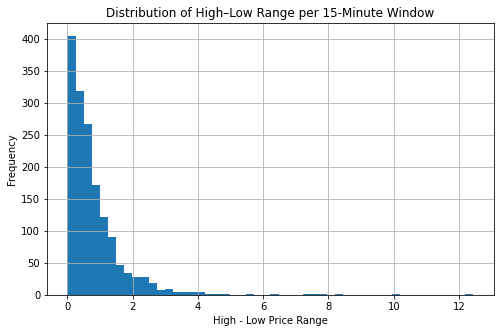

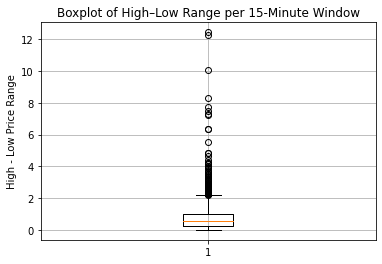

In [0]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# 1) Calculate the high–low range
stock_range_df = stock_df.withColumn("range", F.col("high") - F.col("low"))

# 2) Sample 10% to Pandas for plotting
range_pdf = (
    stock_range_df
      .select("range")
      .sample(fraction=0.1, seed=42)
      .toPandas()
)

# 3) Plot distribution of the range
plt.figure(figsize=(8, 5))
plt.hist(range_pdf["range"].dropna(), bins=50)
plt.title("Distribution of High–Low Range per 15-Minute Window")
plt.xlabel("High - Low Price Range")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4) Boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(range_pdf["range"].dropna(), vert=True)
plt.title("Boxplot of High–Low Range per 15-Minute Window")
plt.ylabel("High - Low Price Range")
plt.grid(True)
plt.show()


In [0]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# assume your original Spark DF is called `spark_df` and has schema:
# [timestamp, open, high, low, close, volume, ...]

# 1) Define a strictly ordered Window over time
time_w = Window.orderBy("timestamp")

# 2) Add the label column as the close price of the *next* row
labeled_df = stock_df.withColumn(
    "label",
    F.lead("close", 1).over(time_w)
)

# 3) Check for any missing/nulls in each column (None found)
missing_counts = labeled_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in labeled_df.columns
])

display(labeled_df)

timestamp,close,high,low,trade_count,open,volume,vwap,label
2024-05-08T08:00:00.000+0000,517.31,517.39,517.31,65,517.37,3394,517.319683,517.63
2024-05-08T08:15:00.000+0000,517.63,517.63,517.4,12,517.41,1391,517.562308,517.26
2024-05-08T08:30:00.000+0000,517.26,517.54,517.26,22,517.54,3239,517.345726,517.18
2024-05-08T08:45:00.000+0000,517.18,517.32,517.18,24,517.32,2069,517.244971,517.3
2024-05-08T09:00:00.000+0000,517.3,517.35,517.15,29,517.16,4638,517.308106,517.27
2024-05-08T09:15:00.000+0000,517.27,517.27,517.16,13,517.16,1385,517.19059,517.35
2024-05-08T09:30:00.000+0000,517.35,517.35,517.19,16,517.19,2515,517.212762,517.35
2024-05-08T09:45:00.000+0000,517.35,517.52,517.35,11,517.45,1161,517.461747,517.22
2024-05-08T10:00:00.000+0000,517.22,517.43,517.08,44,517.3,5984,517.200168,517.27
2024-05-08T10:15:00.000+0000,517.27,517.27,517.12,10,517.12,1423,517.240313,517.17


MLFLOW Test with only stock data

In [0]:
# ----------------------------------------------------
# 0) Imports
# ----------------------------------------------------
import mlflow
import mlflow.spark

from pyspark.sql.window import Window
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# ----------------------------------------------------
# 1) Prepare `stock_df`
# ----------------------------------------------------
# assume `stock_df` has schema: [timestamp, open, high, low, close, volume, trade_count, vwap]
# 1a) compute log-return
stock_df = stock_df.withColumn(
    "log_return",
    F.log(F.col("close") / F.lag("close", 1).over(Window.orderBy("timestamp")))
).na.drop(subset=["log_return"])

# 1b) add the next-window close as our label
label_w = Window.orderBy("timestamp")
df = stock_df.withColumn("label", F.lead("close", 1).over(label_w)) \
             .na.drop(subset=["label"])

# ----------------------------------------------------
# 2) Assemble & scale **only** stock features
# ----------------------------------------------------
feature_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "trade_count",
    "vwap",
    "log_return"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features", outputCol="features",
                            withMean=True, withStd=True)

# ----------------------------------------------------
# 3) Train/test split & evaluator
# ----------------------------------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")

# ----------------------------------------------------
# 4) GBTRegressor run
# ----------------------------------------------------
mlflow.spark.autolog()

with mlflow.start_run(run_name="GBT_only_stock_feats") as run:
    gbt = GBTRegressor(featuresCol="features",
                       labelCol="label",
                       maxIter=50,
                       maxDepth=5)
    pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
    model_gbt    = pipeline_gbt.fit(train_df)
    
    preds_gbt = model_gbt.transform(test_df)
    rmse_gbt  = evaluator.evaluate(preds_gbt)
    mlflow.log_metric("rmse", rmse_gbt)
    print(f"GBT RMSE (stock only) = {rmse_gbt:.4f}")

# ----------------------------------------------------
# 5) XGBRegressor run
# ----------------------------------------------------
with mlflow.start_run(run_name="XGB_only_stock_feats") as run:
    xgb = SparkXGBRegressor(
        features_col="features",
        label_col="label",
        objective="reg:squarederror",
        num_round=100,
        max_depth=5,
        eta=0.1
    )
    pipeline_xgb = Pipeline(stages=[assembler, scaler, xgb])
    model_xgb    = pipeline_xgb.fit(train_df)
    
    preds_xgb = model_xgb.transform(test_df)
    rmse_xgb  = evaluator.evaluate(preds_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    print(f"XGB RMSE (stock only) = {rmse_xgb:.4f}")

print("Done!  Two runs logged: compare them in the MLflow UI under your experiment.")


2025/05/14 19:18:57 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/05/14 19:18:57 INFO mlflow.spark.autologging: Autologging successfully enabled for spark.


GBT RMSE (stock only) = 1.9615


2025-05-14 19:20:43,780 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 5, 'num_round': 100, 'eta': 0.1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-05-14 19:20:51,511 INFO XGBoost-PySpark: _fit Finished xgboost training!


XGB RMSE (stock only) = 0.9429
Done!  Two runs logged: compare them in the MLflow UI under your experiment.
